In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, ndimage
import math
from tqdm.notebook import tqdm
import seaborn as sns
import galsim
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
def crop_normalize(image, length, noise):
    image[image < 0] = 0
    center = np.where(image == np.max(image))
    image = image[center[0][0] - length : center[0][0] + length, center[1][0] - length : center[1][0] + length]
    if noise:
        image = add_noise(image)
    image = image/np.sum(image)
    return image
    
def add_noise(image, level = 1_000):
    image = image + np.random.normal(loc = level, size = (image.shape[0], image.shape[1]))
    
    return image

In [10]:
name = 'FRB'
method = 'FFT'
duration = '15ms'
num_phot = 750000
it = 198

fob_15ms = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
fob_15ms = crop_normalize(fob_15ms, 6, False)
fob_15ms = fob_15ms/np.sum(fob_15ms)

name = 'FRB'
method = 'FFT'
duration = '15s'
num_phot = 750000
it = 101

fob_15s = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
fob_15s = crop_normalize(fob_15s, 6, False)
fob_15s = fob_15s/np.sum(fob_15s)
print(np.sum(fob_15s ))

name = 'FRB'
method = 'FFT'
duration = '150s'
num_phot = 750000
it = 0

fob_150s = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
fob_150s = crop_normalize(fob_150s, 6, False)
fob_150s = fob_150s/np.sum(fob_150s)

x, y = np.mgrid[0:12:1, 0:12:1]
pos = np.dstack((x, y))
rv = st.multivariate_normal([6, 6], [[2.0, 0], [0, 2]])
gaus = rv.pdf(pos)
gaus = gaus/np.sum(gaus)



1.0


<Figure size 432x288 with 0 Axes>

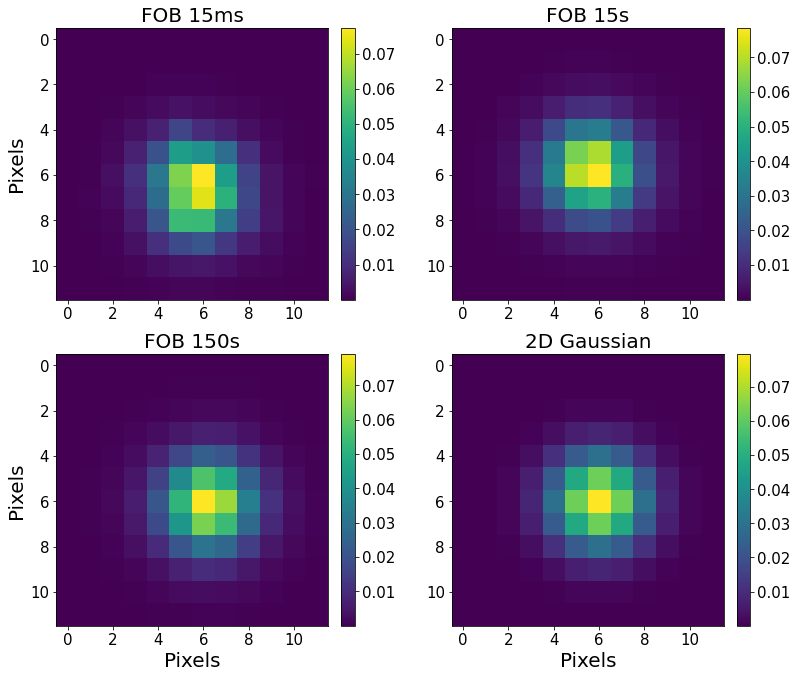

In [11]:


plt.set_cmap('viridis')

plt.figure(figsize = (13,11))
plt.subplot(2,2,1)
plt.title('FOB 15ms', fontsize = 20)
plt.imshow(fob_15ms)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.tick_params(labelsize = 15)
plt.ylabel('Pixels', fontsize = 20)

plt.subplot(2,2,2)
plt.title('FOB 15s', fontsize = 20)
plt.imshow(fob_15s)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.tick_params(labelsize = 15)


plt.subplot(2,2,3)
plt.title('FOB 150s', fontsize = 20)
plt.imshow(fob_150s)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.xlabel('Pixels', fontsize = 20)
plt.ylabel('Pixels', fontsize = 20)
plt.tick_params(labelsize = 15)

plt.subplot(2,2,4)
plt.title('2D Gaussian', fontsize = 20)
plt.imshow(gaus)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.xlabel('Pixels', fontsize = 20)
plt.tick_params(labelsize = 15)



In [12]:
print(chi_square(fob_15ms, gaus))
print(chi_square(fob_15s, gaus))

print('-----')

print(chi_square(fob_15ms, fob_150s))
print(chi_square(fob_15s, fob_150s))

0.6665866061499792
0.3596867171084372
-----
0.26955271633648237
0.20523280491953716


In [9]:
chi = (fob_15ms - gaus)**2/gaus
print(chi.shape)

(12, 12)


In [5]:
def chi_square(image, gaussian):
    chi = (image - gaussian)**2/gaussian
    
    return np.sum(chi)
    
print(chi_square(fob_15ms, gaus)/143)
print(chi_square(fob_15s, gaus)/143)

print('-----')

print(chi_square(fob_15ms, fob_150s)/143)
print(chi_square(fob_15s, fob_150s)/143)

0.004661444798251603
0.0025152917280310294
-----
0.0018849840303250514
0.0014351944399967633


In [16]:
def crop_normalize(image, length, noise):
    image[image < 0] = 0
    center = np.where(image == np.max(image))
    image = image[center[0][0] - length : center[0][0] + length, center[1][0] - length : center[1][0] + length]
    if noise:
        image = add_noise(image)
    image = image/np.sum(image)
    return image

def load_data(name, method, duration, num_simulations, num_phot):
    dat = {
        'chi_150' : [],
        'chi_noise_150' : [],
        'chi_gaus' : [],
        'chi_noise_gaus' : [],
    }
    
    fob_150s = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, 0), delimiter = ',')
    fob_150s = crop_normalize(fob_150s, 6, noise = False)
    fob_150s = fob_150s/np.sum(fob_150s)

    x, y = np.mgrid[0:12:1, 0:12:1]
    pos = np.dstack((x, y))
    rv = st.multivariate_normal([6, 6], [[2.0, 0], [0, 2]])
    gaus = rv.pdf(pos)
    gaus = gaus/np.sum(gaus)

    for it in tqdm(range(num_simulations)):
        image = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
        image_noise = crop_normalize(image, 6, noise = True)
        image_noise = image_noise/np.sum(image_noise)
        
        image = crop_normalize(image, 6, noise = False)
        image = image/np.sum(image)

        chi_noise_150 = chi_square(image_noise, fob_150s)
        chi_150 = chi_square(image, fob_150s)
        chi_noise_gaus = chi_square(image_noise, gaus)
        chi_gaus = chi_square(image, gaus)

        dat['chi_150'].append(chi_150)
        dat['chi_noise_150'].append(chi_noise_150)
        dat['chi_gaus'].append(chi_gaus)
        dat['chi_noise_gaus'].append(chi_noise_gaus)
    
    return dat

In [17]:
fft_15ms_75e5 = load_data('FRB', 'FFT', '15ms', 3000, num_phot = int(7.5e5))
fft_15s_75e5 = load_data('FRB', 'FFT', '15s', 2000, num_phot = int(7.5e5))


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, '15s FOB $\\chi^2$ with noise')

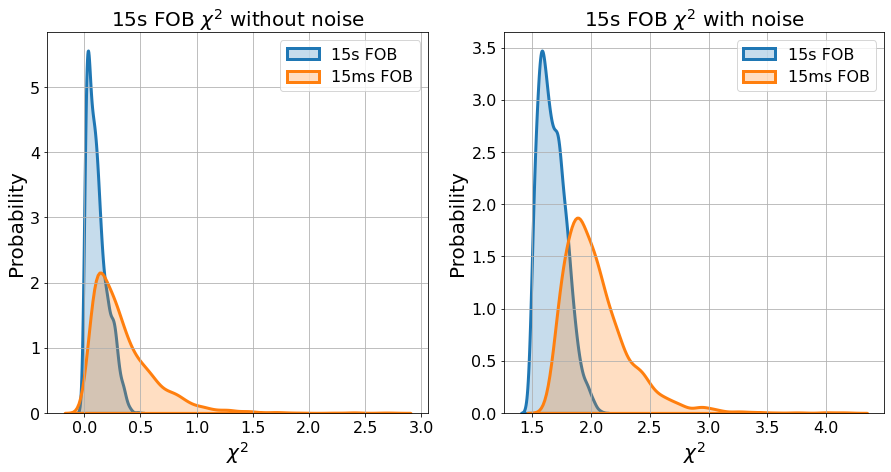

In [19]:
def plot_att(attribute, label, *args):

    for arg in args:
        sns.distplot(arg[0][attribute], hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 3}, label = arg[1])
    plt.grid()
    plt.legend(fontsize = 16)
    plt.tick_params(labelsize = 16)
    plt.xlabel('', fontsize = 20)
    plt.ylabel('', fontsize = 20)
    plt.xlabel(label)
    plt.ylabel('Probability')

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plot_att('chi_150', '$\chi^2$', [fft_15s_75e5, '15s FOB'],
             [fft_15ms_75e5, '15ms FOB'], )
plt.title('15s FOB $\chi^2$ without noise', fontsize = 20)

plt.subplot(1,2,2)
plot_att('chi_noise_150', '$\chi^2$', [fft_15s_75e5, '15s FOB'],
             [fft_15ms_75e5, '15ms FOB'], )
plt.title('15s FOB $\chi^2$ with noise', fontsize = 20)

Text(0.5, 1.0, '2D Gaussian $\\chi^2$ with noise')

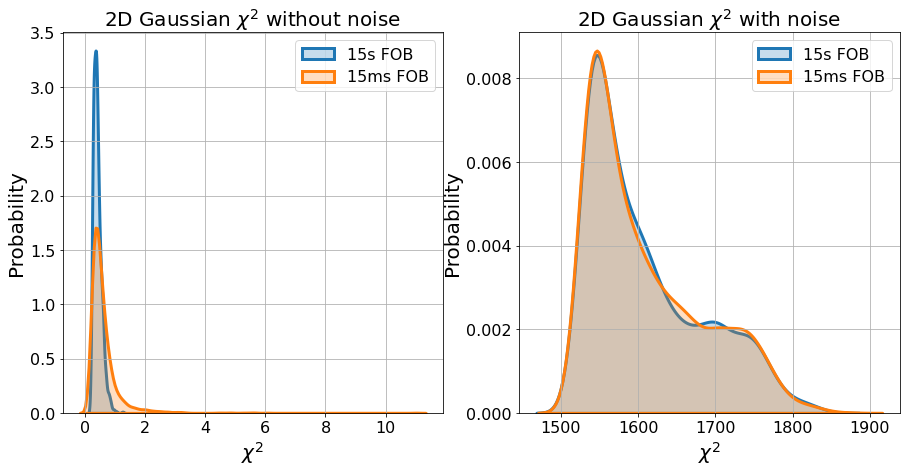

In [20]:
plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plot_att('chi_gaus', '$\chi^2$', [fft_15s_75e5, '15s FOB'],
             [fft_15ms_75e5, '15ms FOB'], )
plt.title('2D Gaussian $\chi^2$ without noise', fontsize = 20)

plt.subplot(1,2,2)
plot_att('chi_noise_gaus', '$\chi^2$', [fft_15s_75e5, '15s FOB'],
             [fft_15ms_75e5, '15ms FOB'], )
plt.title('2D Gaussian $\chi^2$ with noise', fontsize = 20)

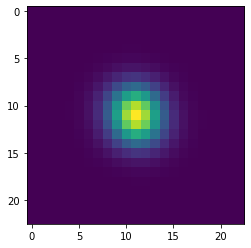

In [72]:
import scipy.signal as sg
corr1 = sg.correlate2d(fob_15ms, fob_15ms)
plt.imshow(corr1)

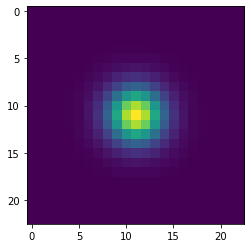

In [73]:
import scipy.signal as sg
corr2 = sg.correlate2d(fob_15s, fob_15s)
plt.imshow(corr2)

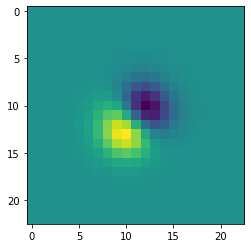

In [74]:
import scipy.signal as sg
corr3 = sg.correlate2d(fob_15ms, fob_150s)
plt.imshow(corr3 - corr2)

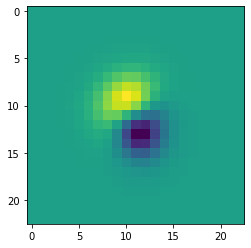

In [65]:
import scipy.signal as sg
corr = sg.correlate2d(fob_150s, fob_150s)
plt.imshow(corr - corr1)

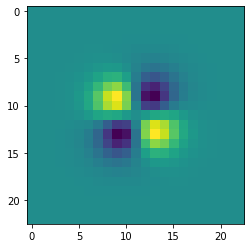

In [51]:
import scipy.signal as sg
corr = sg.correlate2d(fob_150s, fob_150s)
plt.imshow(corr - corr1)

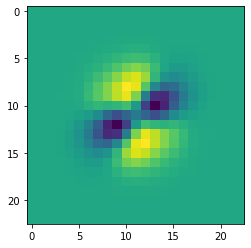

In [46]:
import scipy.signal as sg
corr = sg.correlate2d(fob_150s, fob_150s)
plt.imshow(corr - corr1)

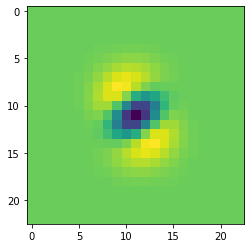

In [40]:
import scipy.signal as sg
corr = sg.correlate2d(fob_150s, fob_150s)
plt.imshow(corr - corr1)

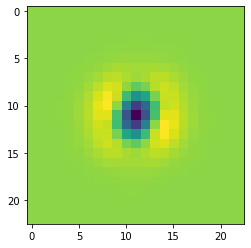

In [38]:
import scipy.signal as sg
corr = sg.correlate2d(fob_150s, fob_150s)
plt.imshow(corr - corr1)

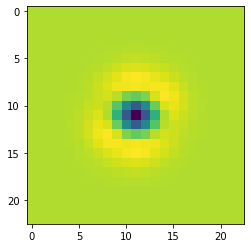

In [34]:
import scipy.signal as sg
corr = sg.correlate2d(fob_150s, fob_150s)
plt.imshow(corr - corr1)

1.0


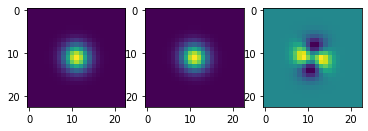

In [104]:
name = 'FRB'
method = 'FFT'
duration = '15ms'
num_phot = 750000
it = 1225

fob_15ms = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
fob_15ms = crop_normalize(fob_15ms, 6, False)
fob_15ms = fob_15ms/np.sum(fob_15ms)

name = 'FRB'
method = 'FFT'
duration = '15s'
num_phot = 750000
it = 151

fob_15s = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
fob_15s = crop_normalize(fob_15s, 6, False)
fob_15s = fob_15s/np.sum(fob_15s)
print(np.sum(fob_15s ))

it = 1525
fob_15s2 = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
fob_15s2 = crop_normalize(fob_15s2, 6, False)
fob_15s2 = fob_15s2/np.sum(fob_15s2)


plt.figure()
plt.subplot(1,3,1)
corr1 = sg.correlate2d(fob_15s2, fob_15s2)
plt.imshow(corr1)
plt.subplot(1,3,2)
corr2 = sg.correlate2d(fob_15s, fob_15s)
plt.imshow(corr2)
plt.subplot(1,3,3)
plt.imshow(corr2 - corr1)



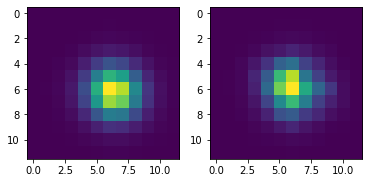

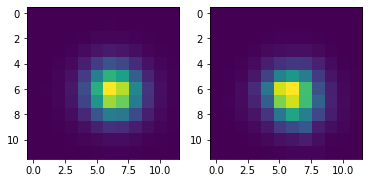

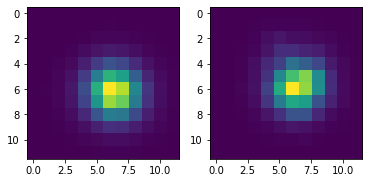

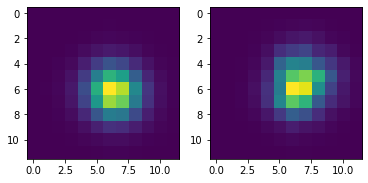

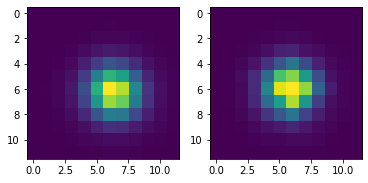

In [106]:
for it in [1125, 23, 299, 587, 432]:
    name = 'FRB'
    method = 'FFT'
    duration = '15ms'
    num_phot = 750000


    fob_15ms = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
    fob_15ms = crop_normalize(fob_15ms, 6, False)
    fob_15ms = fob_15ms/np.sum(fob_15ms)

    name = 'FRB'
    method = 'FFT'
    duration = '15s'
    num_phot = 750000
    it = 151

    fob_15s = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
    fob_15s = crop_normalize(fob_15s, 6, False)
    fob_15s = fob_15s/np.sum(fob_15s)


    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(fob_15s)
    plt.subplot(1,2,2)
    plt.imshow(fob_15ms)
